In [1]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

In [2]:
%ls

 ドライブ C のボリューム ラベルは Windows です
 ボリューム シリアル番号は CA67-50C9 です

 C:\Users\tsk_sato\Documents\DataAnalysisProjects のディレクトリ

2019/03/18  17:36    <DIR>          .
2019/03/18  17:36    <DIR>          ..
2018/08/30  15:52                20 .gitignore
2019/03/18  16:31    <DIR>          .ipynb_checkpoints
2018/08/24  13:25             2,141 anomaly_detection_method_evaluation.py
2018/12/20  10:51    <DIR>          data
2018/09/14  21:21             2,607 EDA_GMS.ipynb
2018/09/13  19:16            23,743 folium_uktaxi.ipynb
2018/08/23  15:12             5,577 GMM_SkillCraft1.ipynb
2018/08/23  15:13             5,697 KDE_SkillCraft1.ipynb
2018/08/30  15:49             9,149 LOF_SkillCraft1.ipynb
2018/08/23  15:13            31,153 MTS_SkillCraft1.ipynb
2018/09/14  18:48    <DIR>          output
2018/09/03  11:16                66 README.md
2019/03/18  17:36            42,241 Template.ipynb
              10 個のファイル             122,394 バイト
               5 個のディレクトリ  111,166,406,656 バイトの空き領域


In [3]:
%time
file_name = "../python_codes/data/SkillCraft1_Dataset.csv"
df = pd.read_csv(file_name, header=0, index_col=None, sep=',')

Wall time: 0 ns


In [4]:
# 行数列数
df.shape

(3395, 20)

In [5]:
# ヘッダ
df.head(3)

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189


In [6]:
# カラムの型
df.dtypes

GameID                    int64
LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [7]:
# 基本統計量
df.describe()

,GameID,LeagueIndex,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,4805.012371,4.184094,117.046947,0.004299,0.000374,4.364654,0.000098,0.000387,0.003463,40.361562,63.739403,5.272988,22.131664,0.001032,6.534021,0.000059,0.000142
std,2719.944851,1.517327,51.945291,0.005284,0.000225,2.360333,0.000166,0.000377,0.000992,17.153570,19.238869,1.494835,7.431719,0.000519,1.857697,0.000111,0.000265
min,52.000000,1.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.093600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2464.500000,3.000000,79.900200,0.001258,0.000204,3.000000,0.000000,0.000140,0.002754,28.957750,50.446600,4.272850,17.000000,0.000683,5.000000,0.000000,0.000000
50%,4874.000000,4.000000,108.010200,0.002500,0.000353,4.000000,0.000040,0.000281,0.003395,36.723500,60.931800,5.095500,22.000000,0.000905,6.000000,0.000000,0.000020
75%,7108.500000,5.000000,142.790400,0.005133,0.000499,6.000000,0.000119,0.000514,0.004027,48.290500,73.681300,6.033600,27.000000,0.001259,8.000000,0.000086,0.000181
max,10095.000000,8.000000,389.831400,0.043088,0.001752,10.000000,0.003019,0.004041,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


In [8]:
# 欠損値確認
df.isnull().any(axis=0)

GameID                  False
LeagueIndex             False
Age                     False
HoursPerWeek            False
TotalHours              False
APM                     False
SelectByHotkeys         False
AssignToHotkeys         False
UniqueHotkeys           False
MinimapAttacks          False
MinimapRightClicks      False
NumberOfPACs            False
GapBetweenPACs          False
ActionLatency           False
ActionsInPAC            False
TotalMapExplored        False
WorkersMade             False
UniqueUnitsMade         False
ComplexUnitsMade        False
ComplexAbilitiesUsed    False
dtype: bool

In [9]:
# 欠損個数確認
df.isnull().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [10]:
# '?'を含む行数を確認
stats = []
for col in df.columns:
    stats.append(
        (col,                                                                      # 列名
         df[col].nunique(),                                                        # ユニークな値をカウント
         (df[col]=='?').sum() * 100 / df.shape[0]                                  # 欠損値の割合
            if not np.issubdtype(df[col].dtype, np.number) else 0.0,              # 数値型か確認
         df[col].value_counts(normalize=True, dropna=False).values[0] * 100,      # 最大派閥に属するカテゴリ割合 
         df[col].dtype)                                                           # 型
    )
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
4,TotalHours,238,1.678940,9.661267,object
3,HoursPerWeek,33,1.649485,12.106038,object
2,Age,29,1.620029,10.515464,object
0,GameID,3395,0.000000,0.029455,int64
12,GapBetweenPACs,3358,0.000000,0.088365,float64
18,ComplexUnitsMade,1110,0.000000,67.187040,float64
17,UniqueUnitsMade,12,0.000000,22.621502,int64
16,WorkersMade,3256,0.000000,0.117820,float64
15,TotalMapExplored,52,0.000000,5.714286,int64
14,ActionsInPAC,3223,0.000000,0.117820,float64


- TotalHours, HoursPerWeek, Age の3つのカラムで欠損値が1.6%程度含まれているが、その意味で除外されるカラムはない
- 最大派閥に含まるカテゴリは最大でも67%程度であり不均衡さはなく、この意味で除外されるカラムはない

In [11]:
# 不均衡カラムの除去
good_cols = list(df.columns)
for col in df.columns:
    rate = df[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)

In [12]:
df = df[good_cols]

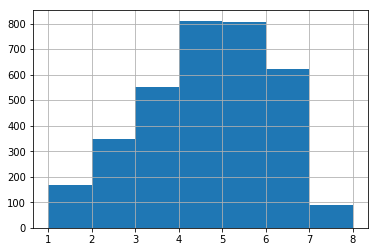

In [13]:
# ターゲットカラム集計
df['LeagueIndex'].hist(bins=7)
plt.show()